# Model Evaluation & Inference: Landcover.ai

Evaluate trained models on the Landcover.ai test set and visualize predictions.

**Contents**:
1. Load pretrained weights
2. Evaluate on test set (Accuracy, IoU, Precision, Recall, F1)
3. Generate confusion matrix
4. Visualize predictions
5. Run inference on new images

## 1. Setup and Configuration

In [1]:
import sys
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
from PIL import Image
import torchvision.transforms.v2 as v2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ============================================================
# CONFIGURATION
# ============================================================

# Paths
DATA_ROOT = Path('../data/landcover.ai.v1')
WEIGHTS_DIR = Path('../weights')
PLOTS_DIR = Path('../plots/landcover')

# Model to evaluate
MODEL_NAME = 'segformer'
WEIGHTS_FILE = WEIGHTS_DIR / f'human_{MODEL_NAME}.pth'
# Alternative: use best checkpoint from training
# WEIGHTS_FILE = Path('../03_model_training/experiments/deeplab_landcover_v1/best_model.pth')

BATCH_SIZE = 16
NUM_WORKERS = 0

# Class definitions
CLASS_NAMES = ['background', 'building', 'woodland', 'water', 'road']
NUM_CLASSES = len(CLASS_NAMES)

# Colors for visualization
CLASS_COLORS = {
    0: [0.8, 0.8, 0.8],  # Background - gray
    1: [1.0, 0.0, 0.0],  # Building - red
    2: [0.0, 0.5, 0.0],  # Woodland - dark green
    3: [0.0, 0.0, 1.0],  # Water - blue
    4: [1.0, 1.0, 0.0],  # Road - yellow
}

PLOTS_DIR.mkdir(parents=True, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
print(f"Model: {MODEL_NAME}")
print(f"Weights: {WEIGHTS_FILE}")

Device: cuda
Model: segformer
Weights: ..\weights\human_segformer.pth


## 2. Dataset Class

In [2]:
class LandcoverAIDataset(Dataset):
    """Landcover.ai dataset loader for evaluation."""
    
    MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    STD = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def __init__(self, root_dir, split_file):
        self.output_dir = Path(root_dir) / 'output'
        
        with open(split_file, 'r') as f:
            self.tile_names = [line.strip() for line in f if line.strip()]
        
        print(f"Loaded {len(self.tile_names)} tiles from {Path(split_file).name}")
    
    def __len__(self):
        return len(self.tile_names)
    
    def __getitem__(self, idx):
        tile_name = self.tile_names[idx]
        image_path = self.output_dir / f"{tile_name}.jpg"
        mask_path = self.output_dir / f"{tile_name}_m.png"
        
        image = np.array(Image.open(image_path))
        if image.ndim == 3 and image.shape[2] == 4:
            image = image[:, :, :3]
        
        mask = np.array(Image.open(mask_path))
        if mask.ndim == 3:
            mask = mask[:, :, 0]
        
        # Convert to tensor
        image_t = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        image_t = (image_t - self.MEAN) / self.STD
        mask_t = torch.from_numpy(mask.astype(np.int64))
        
        return image_t, mask_t, tile_name


print("Dataset class defined")

Dataset class defined


## 3. Load Model and Weights

In [3]:
# Add project root to path
sys.path.insert(0, '../../')

from models import DeepLab, ResNet_UNet, SegFormer

print("=== Loading Model ===")
print()

# Initialize model
if MODEL_NAME == 'deeplab':
    model = DeepLab(
        num_classes=NUM_CLASSES,
        input_image_size=512,
        backbone='resnet50',
        output_stride=4
    )
elif MODEL_NAME == 'resnet_unet':
    model = ResNet_UNet(num_classes=NUM_CLASSES)
elif MODEL_NAME == 'segformer':
    model = SegFormer(num_classes=NUM_CLASSES)
else:
    raise ValueError(f"Unknown model: {MODEL_NAME}")

# Load weights
if WEIGHTS_FILE.exists():
    state_dict = torch.load(WEIGHTS_FILE, map_location=device)
    model.load_state_dict(state_dict)
    print(f"Loaded weights from: {WEIGHTS_FILE}")
else:
    print(f"WARNING: Weights file not found: {WEIGHTS_FILE}")
    print("Using randomly initialized model")

model = model.to(device)
model.eval()

num_params = sum(p.numel() for p in model.parameters())
print(f"\nModel: {MODEL_NAME}")
print(f"Parameters: {num_params:,}")

c:\Users\adytc\anaconda3\envs\mangrove\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Loading Model ===



Loading weights: 100%|██████████| 364/364 [00:00<00:00, 1231.48it/s, Materializing param=encoder.patch_embeddings.3.proj.weight]            
SegformerModel LOAD REPORT from: nvidia/segformer-b2-finetuned-ade-512-512
Key                                           | Status     |  | 
----------------------------------------------+------------+--+-
decode_head.batch_norm.bias                   | UNEXPECTED |  | 
decode_head.linear_c.{0, 1, 2, 3}.proj.bias   | UNEXPECTED |  | 
decode_head.batch_norm.running_mean           | UNEXPECTED |  | 
decode_head.linear_c.{0, 1, 2, 3}.proj.weight | UNEXPECTED |  | 
decode_head.classifier.weight                 | UNEXPECTED |  | 
decode_head.linear_fuse.weight                | UNEXPECTED |  | 
decode_head.batch_norm.weight                 | UNEXPECTED |  | 
decode_head.batch_norm.num_batches_tracked    | UNEXPECTED |  | 
decode_head.batch_norm.running_var            | UNEXPECTED |  | 
decode_head.classifier.bias                   | UNEXPECTED |  | 

Not

Loaded weights from: ..\weights\human_segformer.pth

Model: segformer
Parameters: 33,255,237


## 4. Load Test Dataset

In [4]:
print("=== Loading Test Dataset ===")
print()

test_dataset = LandcoverAIDataset(DATA_ROOT, DATA_ROOT / 'test.txt')

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"\nTest samples: {len(test_dataset):,}")
print(f"Test batches: {len(test_loader):,}")

=== Loading Test Dataset ===

Loaded 1602 tiles from test.txt

Test samples: 1,602
Test batches: 101


## 5. Evaluation Metrics Functions

In [5]:
def compute_metrics(pred, target, num_classes, ignore_index=None):
    """
    Compute segmentation metrics.
    
    Returns:
        dict with pixel_accuracy, mean_iou, class_iou, precision, recall, f1
    """
    pred = pred.flatten()
    target = target.flatten()
    
    # Mask out ignore pixels
    if ignore_index is not None:
        valid = target != ignore_index
        pred = pred[valid]
        target = target[valid]
    
    # Pixel accuracy
    pixel_acc = (pred == target).sum() / len(target)
    
    # Per-class metrics
    class_iou = []
    class_precision = []
    class_recall = []
    class_f1 = []
    
    for c in range(num_classes):
        pred_c = pred == c
        target_c = target == c
        
        tp = (pred_c & target_c).sum()
        fp = (pred_c & ~target_c).sum()
        fn = (~pred_c & target_c).sum()
        
        # IoU
        iou = tp / (tp + fp + fn + 1e-10)
        class_iou.append(iou)
        
        # Precision, Recall, F1
        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * precision * recall / (precision + recall + 1e-10)
        
        class_precision.append(precision)
        class_recall.append(recall)
        class_f1.append(f1)
    
    return {
        'pixel_accuracy': float(pixel_acc),
        'mean_iou': float(np.mean(class_iou)),
        'class_iou': [float(x) for x in class_iou],
        'class_precision': [float(x) for x in class_precision],
        'class_recall': [float(x) for x in class_recall],
        'class_f1': [float(x) for x in class_f1],
    }


print("Metrics functions defined")

Metrics functions defined


## 6. Run Evaluation

In [11]:
print("=== Running Evaluation ===")
print()

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, masks, _ in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        
        # Get predictions
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.append(preds.cpu().numpy())
        all_targets.append(masks.numpy())

# Concatenate all predictions
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

print(f"\nPredictions shape: {all_preds.shape}")
print(f"Targets shape: {all_targets.shape}")

=== Running Evaluation ===



Evaluating: 100%|██████████| 101/101 [38:28<00:00, 22.85s/it]



Predictions shape: (1602, 512, 512)
Targets shape: (1602, 512, 512)


In [12]:
# Compute metrics
print("=== Computing Metrics ===")
print()

metrics = compute_metrics(all_preds, all_targets, NUM_CLASSES)

print(f"Overall Metrics:")
print(f"  Pixel Accuracy: {metrics['pixel_accuracy']:.4f}")
print(f"  Mean IoU:       {metrics['mean_iou']:.4f}")
print()

print(f"Per-Class Metrics:")
print(f"{'Class':<12} {'IoU':>8} {'Precision':>10} {'Recall':>8} {'F1':>8}")
print("-" * 50)
for i, name in enumerate(CLASS_NAMES):
    print(f"{name:<12} {metrics['class_iou'][i]:>8.4f} {metrics['class_precision'][i]:>10.4f} {metrics['class_recall'][i]:>8.4f} {metrics['class_f1'][i]:>8.4f}")

=== Computing Metrics ===

Overall Metrics:
  Pixel Accuracy: 0.9499
  Mean IoU:       0.8187

Per-Class Metrics:
Class             IoU  Precision   Recall       F1
--------------------------------------------------
background     0.9195     0.9712   0.9452   0.9580
building       0.7201     0.7635   0.9268   0.8373
woodland       0.9001     0.9335   0.9617   0.9474
water          0.9335     0.9581   0.9733   0.9656
road           0.6201     0.7277   0.8075   0.7655


## 7. Confusion Matrix

=== Generating Confusion Matrix ===



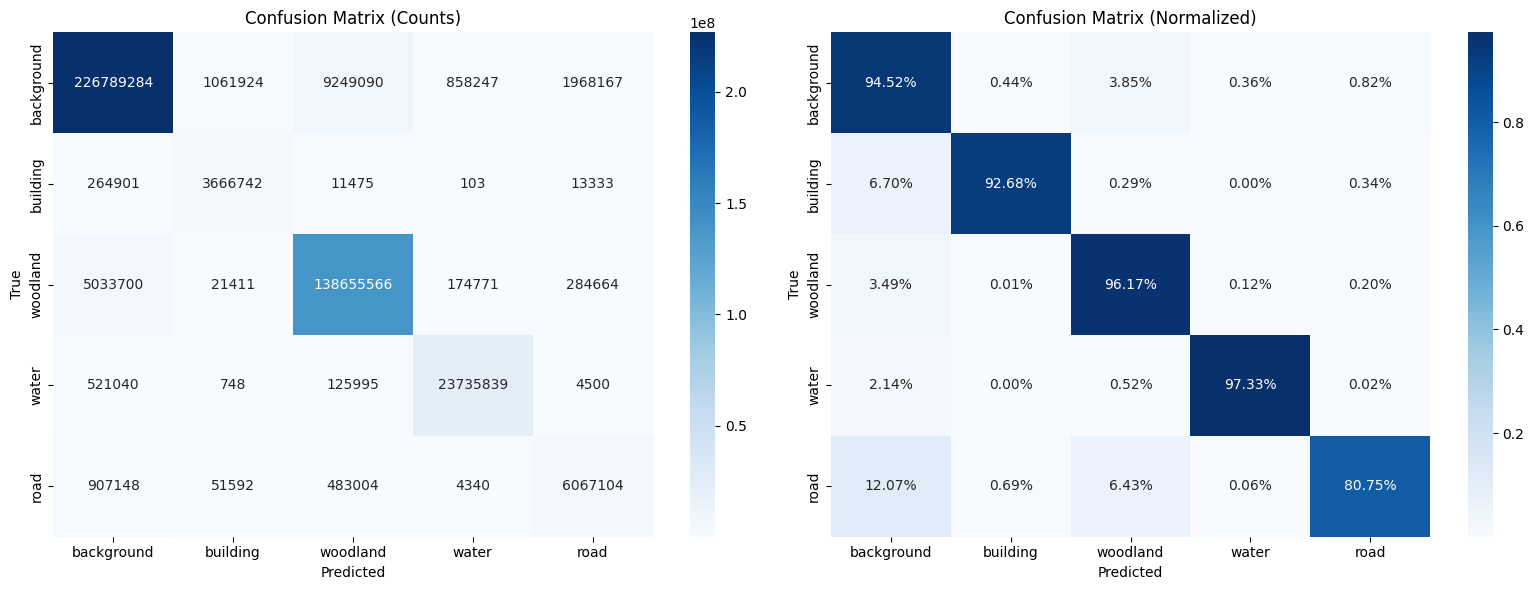

Saved: ..\plots\landcover\segformer_confusion_matrix.png


In [13]:
print("=== Generating Confusion Matrix ===")
print()

# Flatten for confusion matrix
preds_flat = all_preds.flatten()
targets_flat = all_targets.flatten()

# Compute confusion matrix
cm = confusion_matrix(targets_flat, preds_flat, labels=range(NUM_CLASSES))

# Normalize by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.savefig(PLOTS_DIR / f'{MODEL_NAME}_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {PLOTS_DIR / f'{MODEL_NAME}_confusion_matrix.png'}")

## 8. Per-Class IoU Bar Chart

=== Plotting Per-Class IoU ===



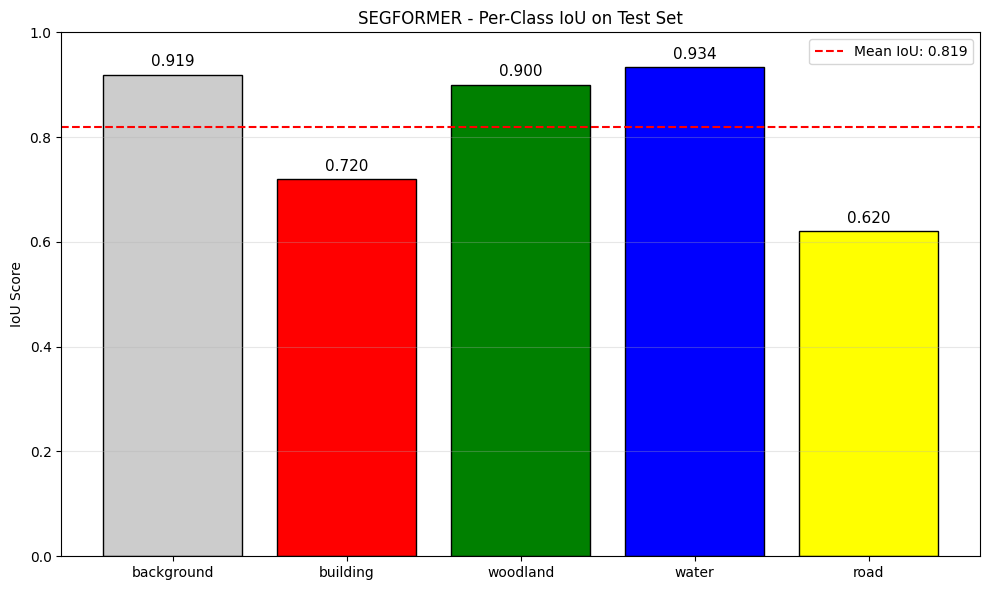

Saved: ..\plots\landcover\segformer_class_iou.png


In [14]:
print("=== Plotting Per-Class IoU ===")
print()

fig, ax = plt.subplots(figsize=(10, 6))

colors = [CLASS_COLORS[i] for i in range(NUM_CLASSES)]
bars = ax.bar(CLASS_NAMES, metrics['class_iou'], color=colors, edgecolor='black')

# Add value labels on bars
for bar, iou in zip(bars, metrics['class_iou']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{iou:.3f}', ha='center', va='bottom', fontsize=11)

# Add mean line
ax.axhline(y=metrics['mean_iou'], color='red', linestyle='--', 
           label=f"Mean IoU: {metrics['mean_iou']:.3f}")

ax.set_ylabel('IoU Score')
ax.set_title(f'{MODEL_NAME.upper()} - Per-Class IoU on Test Set')
ax.set_ylim(0, 1.0)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / f'{MODEL_NAME}_class_iou.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {PLOTS_DIR / f'{MODEL_NAME}_class_iou.png'}")

## 9. Visualize Predictions

In [6]:
def denormalize(img):
    """Reverse ImageNet normalization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    return torch.clamp(img * std + mean, 0, 1)


def mask_to_rgb(mask, class_colors):
    """Convert class mask to RGB image."""
    h, w = mask.shape
    rgb = np.zeros((h, w, 3))
    for class_id, color in class_colors.items():
        rgb[mask == class_id] = color
    return rgb


def visualize_sample(model, dataset, idx, save_path=None):
    """Visualize a single sample with prediction."""
    model.eval()
    torch.cuda.empty_cache()  # Free up VRAM from evaluation
    
    img, mask, tile_name = dataset[idx]
    
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
    
    # Prepare for display
    img_np = denormalize(img).numpy().transpose(1, 2, 0)
    mask_np = mask.numpy()
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Sample: {tile_name}', fontsize=12)
    
    # Image
    axes[0].imshow(img_np)
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    # Ground truth
    axes[1].imshow(mask_to_rgb(mask_np, CLASS_COLORS))
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    # Prediction
    axes[2].imshow(mask_to_rgb(pred_mask, CLASS_COLORS))
    axes[2].set_title('Prediction')
    axes[2].axis('off')
    
    # Overlay
    pred_rgb = mask_to_rgb(pred_mask, CLASS_COLORS)
    overlay = 0.6 * img_np + 0.4 * pred_rgb
    axes[3].imshow(np.clip(overlay, 0, 1))
    axes[3].set_title('Overlay')
    axes[3].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()


print("Visualization functions defined")

Visualization functions defined


=== Visualizing Random Samples ===

Sample 1/4 (index=592)


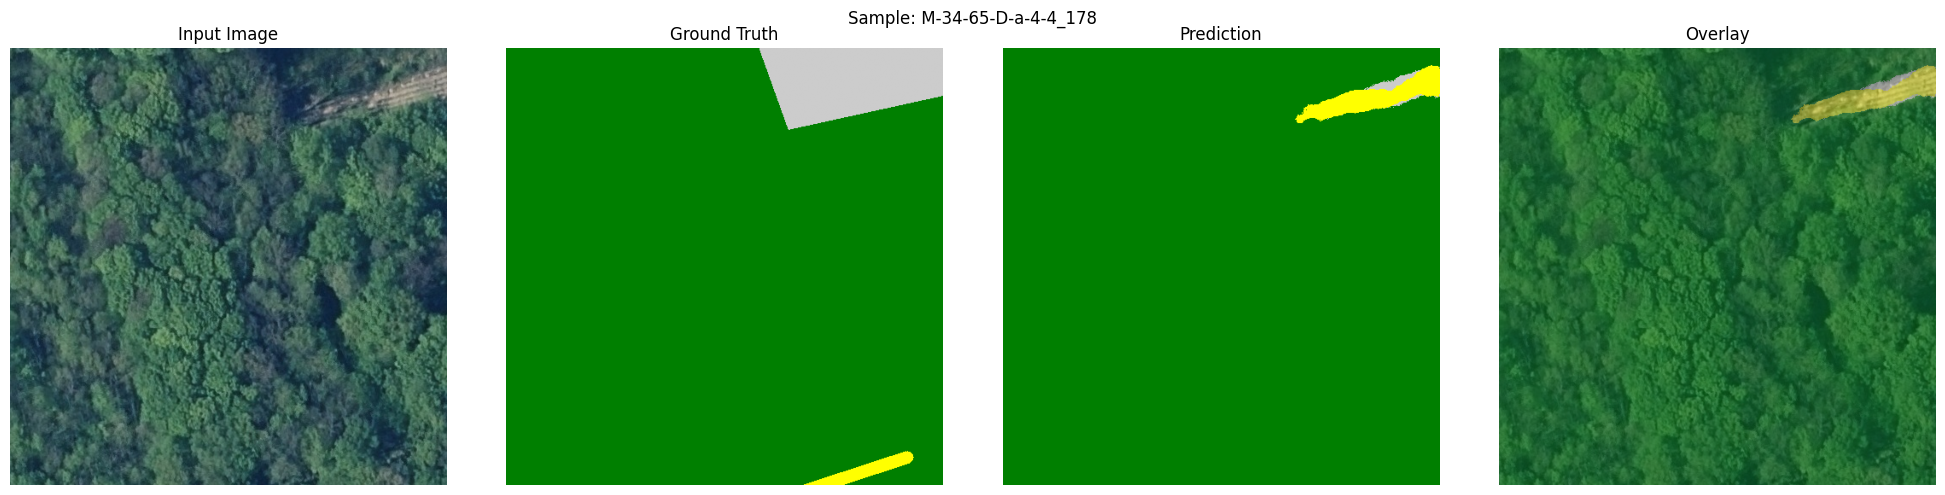

Sample 2/4 (index=453)


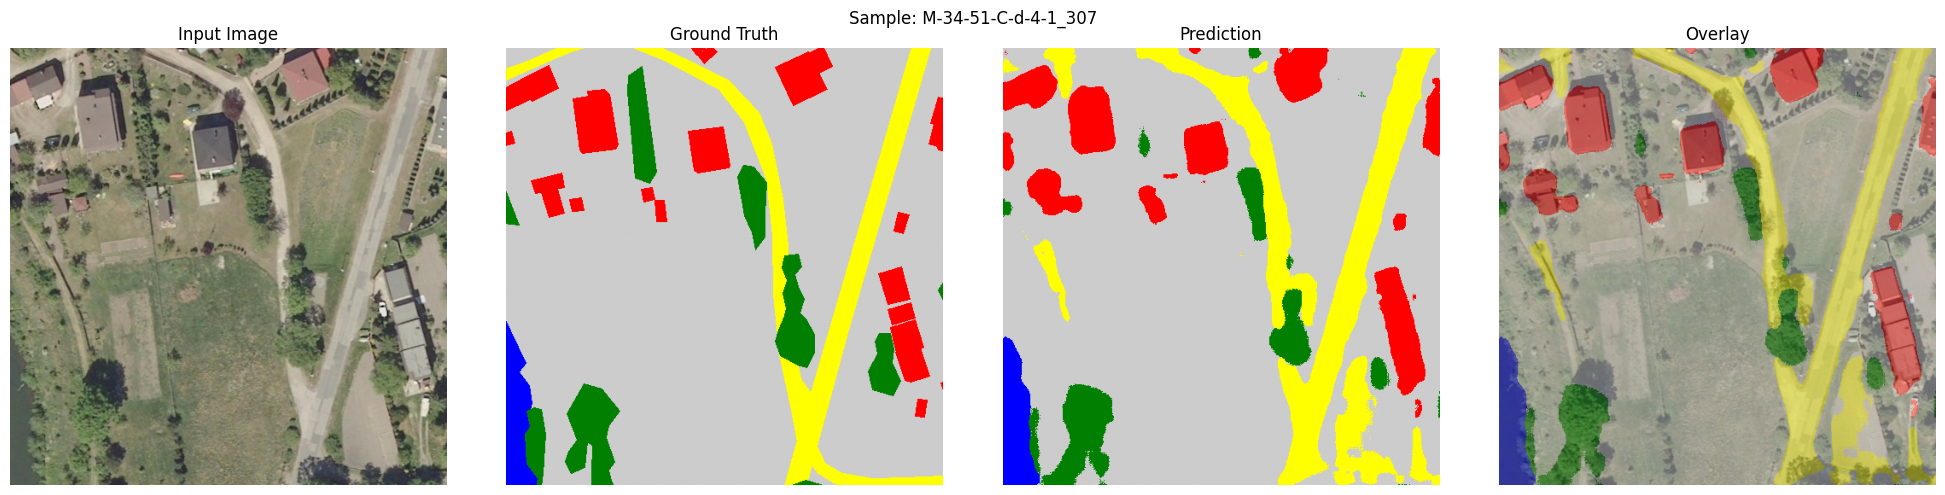

Sample 3/4 (index=1075)


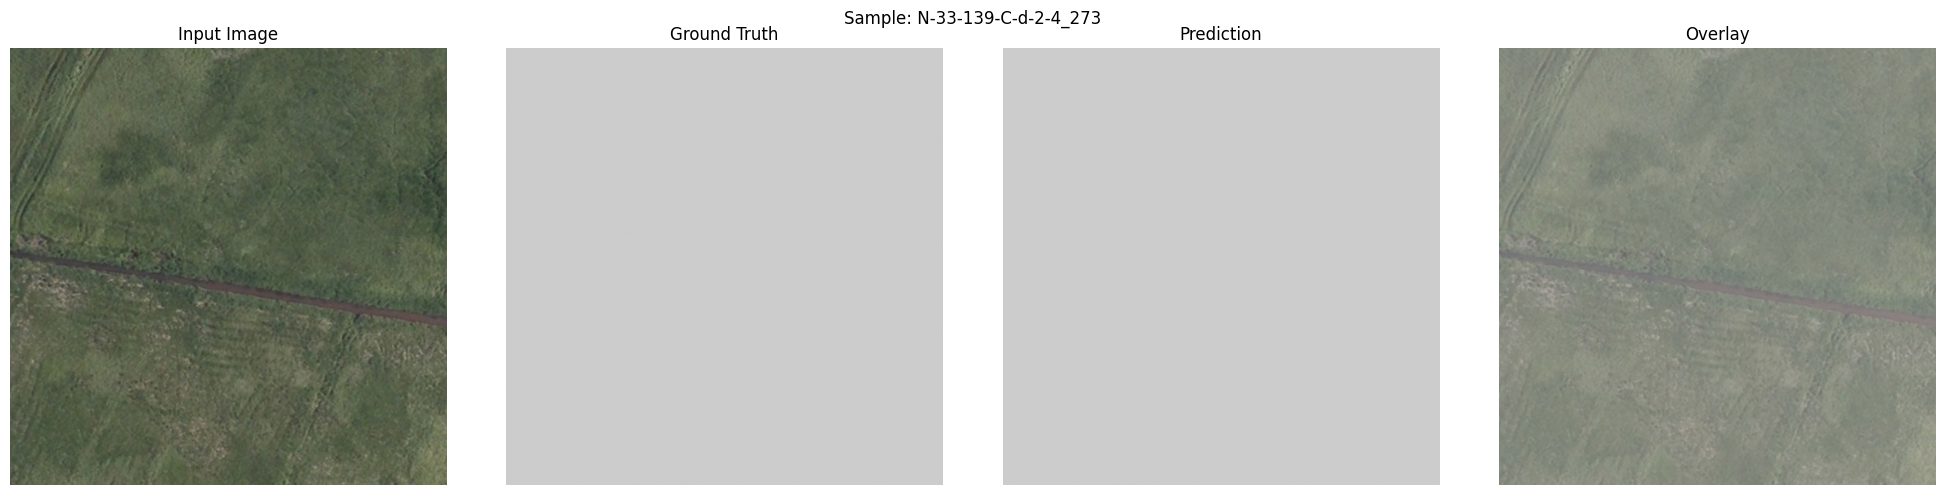

Sample 4/4 (index=978)


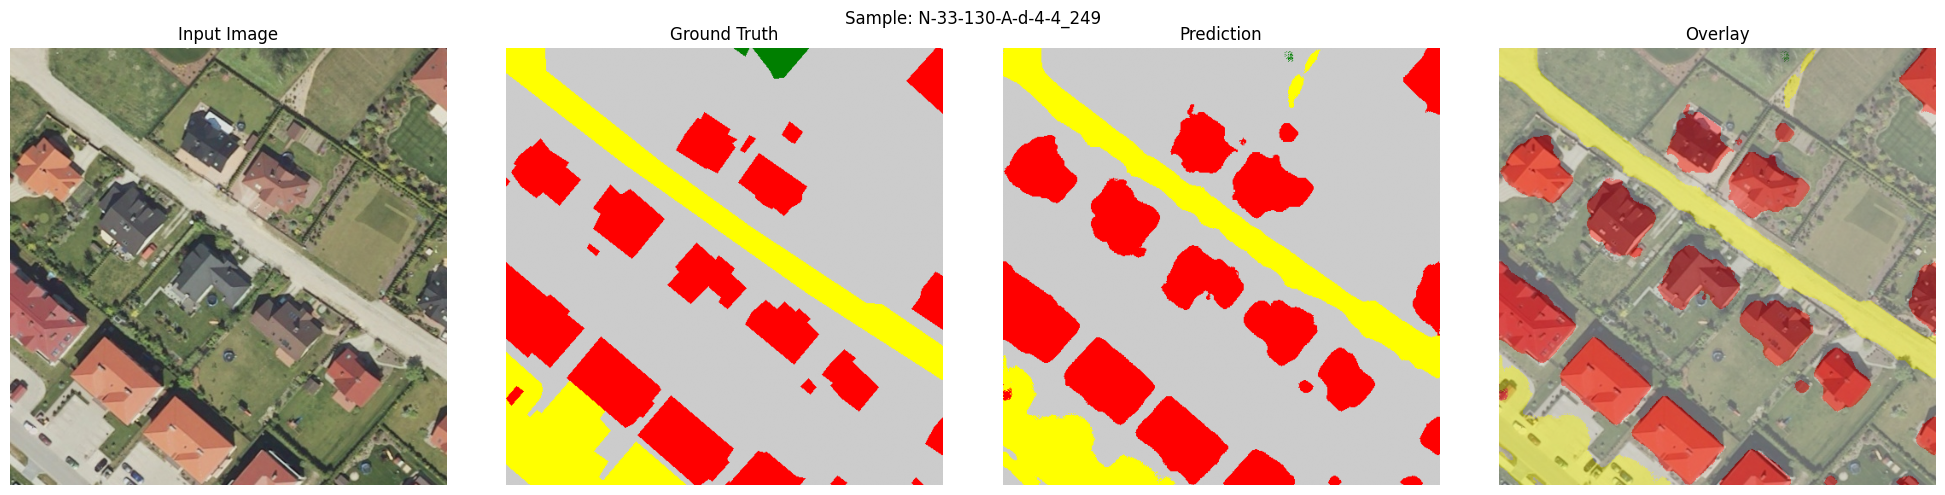

In [22]:
print("=== Visualizing Random Samples ===")
print()

# Visualize 4 random samples
np.random.seed(167)
sample_indices = np.random.choice(len(test_dataset), 4, replace=False)

for i, idx in enumerate(sample_indices):
    print(f"Sample {i+1}/{len(sample_indices)} (index={idx})")
    visualize_sample(model, test_dataset, idx)

## 10. Grid Visualization

=== Creating Grid Visualization ===



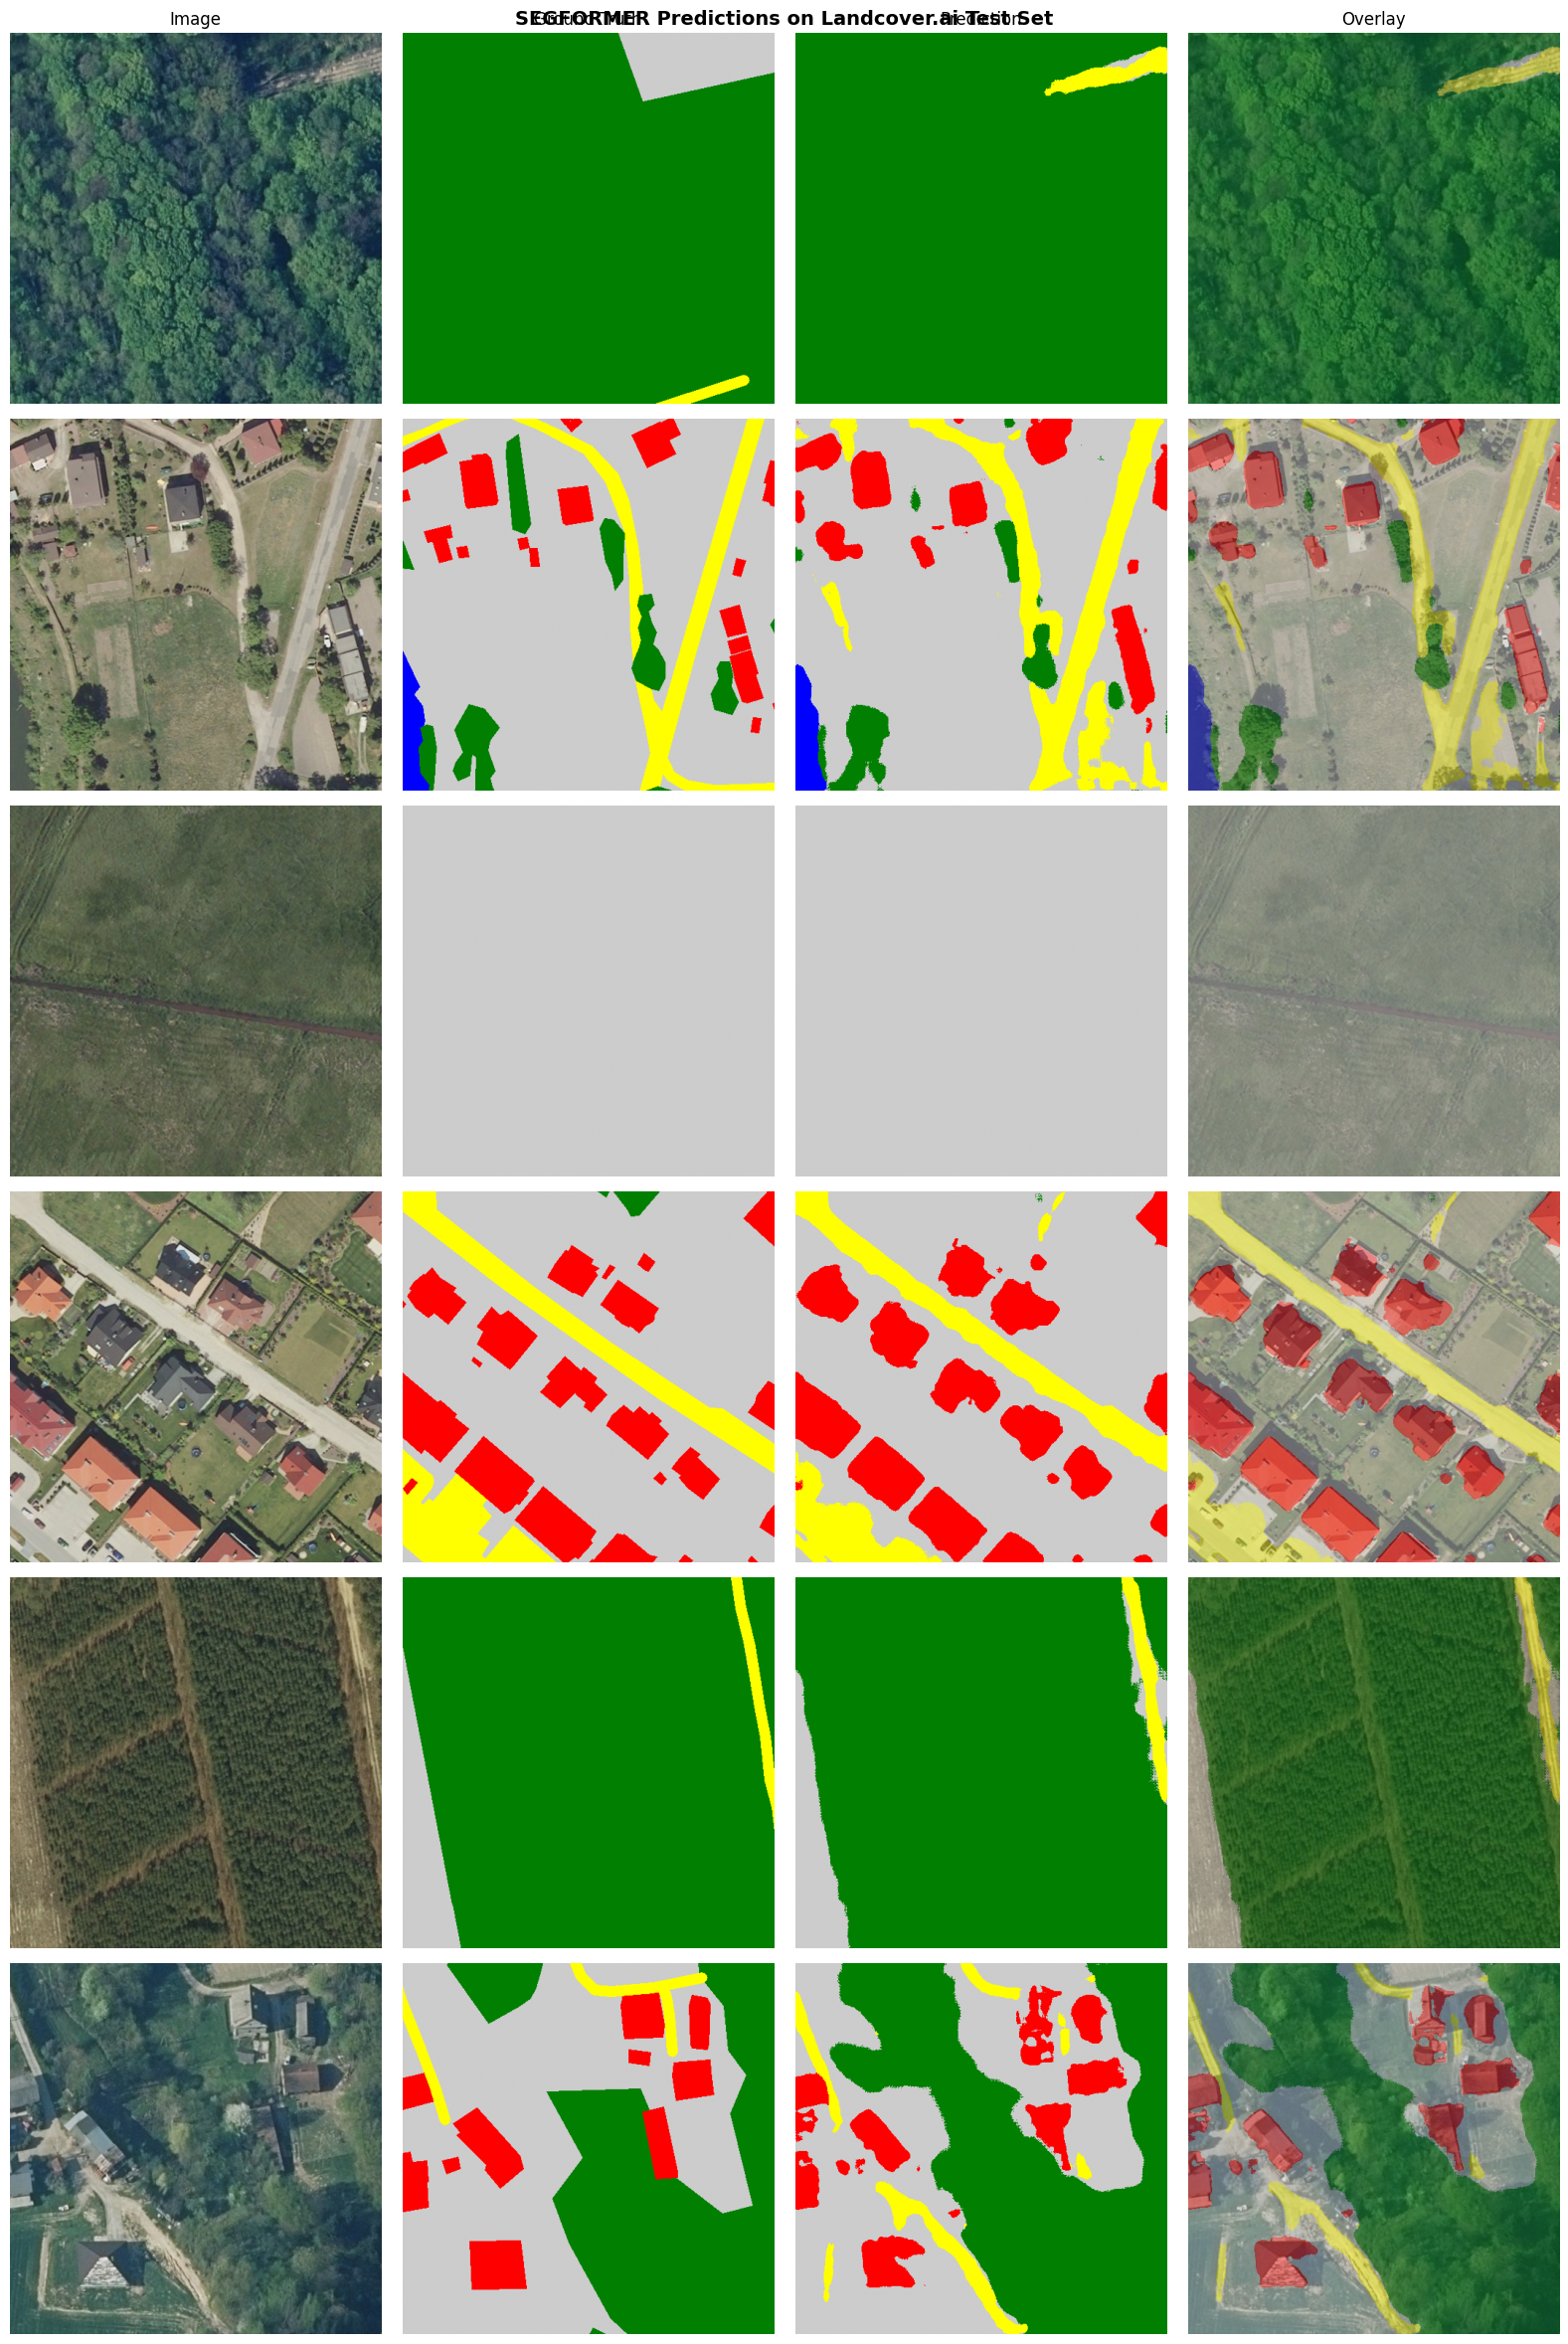

Saved: ..\plots\landcover\segformer_predictions_grid.png


In [25]:
print("=== Creating Grid Visualization ===")
print()

n_samples = 6
np.random.seed(167)
sample_indices = np.random.choice(len(test_dataset), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
fig.suptitle(f'{MODEL_NAME.upper()} Predictions on Landcover.ai Test Set', fontsize=14, fontweight='bold')
torch.cuda.empty_cache()  # Free up VRAM from evaluation

model.eval()
with torch.no_grad():
    for row, idx in enumerate(sample_indices):
        img, mask, tile_name = test_dataset[idx]
        
        pred = model(img.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
        
        img_np = denormalize(img).numpy().transpose(1, 2, 0)
        mask_np = mask.numpy()
        
        axes[row, 0].imshow(img_np)
        axes[row, 0].set_title('Image' if row == 0 else '')
        axes[row, 0].axis('off')
        
        axes[row, 1].imshow(mask_to_rgb(mask_np, CLASS_COLORS))
        axes[row, 1].set_title('Ground Truth' if row == 0 else '')
        axes[row, 1].axis('off')
        
        axes[row, 2].imshow(mask_to_rgb(pred_mask, CLASS_COLORS))
        axes[row, 2].set_title('Prediction' if row == 0 else '')
        axes[row, 2].axis('off')
        
        overlay = 0.6 * img_np + 0.4 * mask_to_rgb(pred_mask, CLASS_COLORS)
        axes[row, 3].imshow(np.clip(overlay, 0, 1))
        axes[row, 3].set_title('Overlay' if row == 0 else '')
        axes[row, 3].axis('off')

plt.tight_layout()
plt.savefig(PLOTS_DIR / f'{MODEL_NAME}_predictions_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {PLOTS_DIR / f'{MODEL_NAME}_predictions_grid.png'}")

## 11. Inference on New Image

In [ ]:
def run_inference(model, image_path, save_path=None):
    """
    Run inference on a single image file.
    
    Args:
        model: Trained model
        image_path: Path to input image (jpg/png)
        save_path: Optional path to save result
    
    Returns:
        pred_mask: Predicted segmentation mask
    """
    model.eval()
    
    # Load and preprocess image
    image = np.array(Image.open(image_path))
    if image.ndim == 3 and image.shape[2] == 4:
        image = image[:, :, :3]
    
    # Store original for display
    img_display = image.copy()
    
    # Normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = image.astype(np.float32) / 255.0
    image = (image - mean) / std
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    
    # Run inference
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Inference: {Path(image_path).name}', fontsize=12)
    
    axes[0].imshow(img_display)
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    axes[1].imshow(mask_to_rgb(pred_mask, CLASS_COLORS))
    axes[1].set_title('Prediction')
    axes[1].axis('off')
    
    overlay = 0.6 * (img_display / 255.0) + 0.4 * mask_to_rgb(pred_mask, CLASS_COLORS)
    axes[2].imshow(np.clip(overlay, 0, 1))
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    
    return pred_mask


print("Inference function defined")
print()
print("Usage:")
print("  pred_mask = run_inference(model, 'path/to/image.jpg')")

In [ ]:
# Example: Run inference on a test image
# Uncomment and modify the path to run on your own image

# sample_image = DATA_ROOT / 'output' / f"{test_dataset.tile_names[0]}.jpg"
# pred = run_inference(model, sample_image, save_path=PLOTS_DIR / 'inference_example.png')

## 12. Save Evaluation Results

In [ ]:
print("=== Saving Evaluation Results ===")
print()

results = {
    'model_name': MODEL_NAME,
    'weights_file': str(WEIGHTS_FILE),
    'num_test_samples': len(test_dataset),
    'num_classes': NUM_CLASSES,
    'class_names': CLASS_NAMES,
    'metrics': metrics
}

results_file = PLOTS_DIR / f'{MODEL_NAME}_evaluation_results.json'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Saved: {results_file}")
print()
print("All outputs saved to:", PLOTS_DIR)

## 13. Summary

In [ ]:
print("=" * 60)
print("Evaluation Summary")
print("=" * 60)
print()
print(f"Model: {MODEL_NAME}")
print(f"Dataset: Landcover.ai v1 Test Set")
print(f"Samples: {len(test_dataset):,}")
print()
print(f"Results:")
print(f"  Pixel Accuracy: {metrics['pixel_accuracy']:.4f}")
print(f"  Mean IoU:       {metrics['mean_iou']:.4f}")
print()
print(f"Per-Class IoU:")
for i, name in enumerate(CLASS_NAMES):
    print(f"  {name}: {metrics['class_iou'][i]:.4f}")
print()
print(f"Saved outputs:")
print(f"  - {MODEL_NAME}_confusion_matrix.png")
print(f"  - {MODEL_NAME}_class_iou.png")
print(f"  - {MODEL_NAME}_predictions_grid.png")
print(f"  - {MODEL_NAME}_evaluation_results.json")